### Kernelized Support Vector Machine

#### Apply a Gaussian (RBF) kernel function
$$k(x_1,x_2) = \phi(x_1) \phi(x_2) = \exp \left(\dfrac{-(x_1-x_2)^2}{2\sigma^2}\right)$$

#### Prediction now becomes
$$\phi(x)^T w^* = \phi(x)^T \sum_{i=1}^n y_i \lambda_i^*\phi(x_i)$$

In [1]:
from Support_Vector_Machine import get_train_valid
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cvxopt

In [2]:
# Define kernel function

def rbf_kernel(x1,x2,sigma=5.0):
    return np.exp(-np.linalg.norm(x1-x2)**2 / (2*(sigma**2)))

In [3]:
# Define function to generate Gram matrix 

def get_Gram(X,sigma):
    
    m,n = X.shape
    
    # Gram matrix
    K = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            K[i,j] = rbf_kernel(X[i],X[j],sigma)
    
    return K

In [4]:
def rbf_svm_train(X_train,y_train,C):
    
    
    y_train = np.array(y_train)
    X_train = np.array(X_train)
    m = X_train.shape[0]
    # Convert to cvxopt format
    P = cvxopt.matrix(np.outer(y_train,y_train)*K)
    q = cvxopt.matrix(-np.ones((m,1)))
    G = cvxopt.matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = cvxopt.matrix(np.hstack((np.zeros(m),np.ones(m)*C)))
    A = cvxopt.matrix(y_train.reshape(1,-1))
    b = cvxopt.matrix(np.zeros(1))
    
    # Solve QP problem
    sol = cvxopt.solvers.qp(P,q,G,h,A,b)
    
    # Compute the parameters
    # Support vectors have non-zero lambdas
    a = np.ravel(sol['x'])
    sv = a > 1e-5
    ind = np.arange(len(a))[sv]
    true_a = a[sv]
    true_sv = X_train[sv]
    true_svy = y_train[sv]
    
    
    # intercept
    b0 = 0
    for n in range(len(true_a)):
        b0 += true_svy[n]
        b0 -= np.sum(true_a * true_svy * K[ind[n],sv])
    b0 /= len(true_a)
    
    return true_a, true_sv, true_svy, b0
    

In [5]:
# Predicting function

def rbf_svm_predict(X,true_a,true_svy,true_sv,b0):
    
    m = len(X)
    y_predict = np.zeros(m)
    
    for i in range(m):
        s = 0
        for a,sv_y,sv in zip(true_a, true_svy,true_sv):
            s += a * sv_y * rbf_kernel(X[i], sv)
        y_predict[i] = s
        
    return np.sign(y_predict + b0)

In [10]:
# Load data
df = pd.read_csv("hw2data.csv",header=None)
df.columns = ['x1','x2','y']
n,p = df.shape

# Partition the data into training and testing sets

# Training: first 80%; Testing: last 20%
df_train = df.iloc[0:int(0.8*n),:]
df_test = df.iloc[-int(0.2*n):,:]


# Random shuffle and split data
np.random.seed(1)
df_train = df_train.sample(frac=1)
k = 10
df_splitted = np.split(df_train,k,axis = 0)


In [11]:
# For efficiency, use 10% of the training set to get a sigma.
np.random.seed(1)
df_train_half = df_train.sample(frac=1/10)

k = 5 # Do a 5-fold CV
df_splitted = np.split(df_train_half,k,axis = 0)


C = 10 # From the smallest test error in hw2.svm.py

sigmas = [1,3,5,6,7,8,10,20]

Err_sig_train = []
Err_sig_valid = []
for sig in sigmas:
    err_sig_train = []
    err_sig_valid = []
    for i in range(k):
        X_valid, y_valid, X_train, y_train = get_train_valid(df_splitted, i, k)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_valid = np.array(X_valid)
        y_valid = np.array(y_valid)
        # Getting Gram matrix K
        K = get_Gram(X=X_train,sigma=sig)
        
        # Fitting model
        a,sv,svy,b0 = rbf_svm_train(X_train,y_train,C)
        
        # Predicting and calculating errors
        y_predict_train = rbf_svm_predict(X=X_train,true_a=a,true_svy=svy,true_sv=sv,b0=b0)
        y_predict_valid = rbf_svm_predict(X=X_valid,true_a=a,true_svy=svy,true_sv=sv,b0=b0)
        
        err_train = np.sum((y_predict_train!=y_train)*1)/len(y_train)
        err_valid = np.sum((y_predict_valid!=y_valid)*1)/len(y_valid)
        err_sig_train.append(err_train)
        err_sig_valid.append(err_valid)
        
    Err_sig_train.append(np.average(err_sig_train))
    Err_sig_valid.append(np.average(err_sig_valid))
        

     pcost       dcost       gap    pres   dres
 0:  2.1505e+02 -6.2493e+03  1e+04  3e-01  5e-15
 1:  1.2099e+02 -8.1910e+02  1e+03  1e-02  5e-15
 2: -7.8167e+01 -3.1447e+02  2e+02  2e-03  4e-15
 3: -1.4598e+02 -2.3668e+02  9e+01  6e-04  5e-15
 4: -1.6942e+02 -2.1391e+02  4e+01  2e-04  6e-15
 5: -1.8362e+02 -1.9565e+02  1e+01  5e-05  6e-15
 6: -1.8861e+02 -1.9056e+02  2e+00  2e-06  7e-15
 7: -1.8930e+02 -1.8967e+02  4e-01  4e-07  6e-15
 8: -1.8944e+02 -1.8950e+02  6e-02  6e-15  8e-15
 9: -1.8946e+02 -1.8947e+02  2e-03  6e-16  8e-15
10: -1.8946e+02 -1.8946e+02  3e-05  2e-15  9e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.7162e+02 -6.2137e+03  1e+04  3e-01  6e-15
 1:  8.3939e+01 -8.6218e+02  1e+03  1e-02  5e-15
 2: -9.7570e+01 -3.1180e+02  2e+02  2e-03  4e-15
 3: -1.5487e+02 -2.5547e+02  1e+02  9e-04  5e-15
 4: -1.7998e+02 -2.2582e+02  5e+01  4e-04  5e-15
 5: -1.9649e+02 -2.0627e+02  1e+01  5e-05  6e-15
 6: -1.9987e+02 -2.0295e+02  3e+00  1e-05  7e-1

     pcost       dcost       gap    pres   dres
 0: -6.2452e+02 -3.3283e+03  3e+03  3e-15  1e-14
 1: -7.8784e+02 -1.1746e+03  4e+02  1e-16  1e-14
 2: -9.8502e+02 -1.0804e+03  1e+02  1e-14  2e-14
 3: -1.0191e+03 -1.0526e+03  3e+01  2e-15  2e-14
 4: -1.0288e+03 -1.0455e+03  2e+01  2e-14  2e-14
 5: -1.0335e+03 -1.0424e+03  9e+00  1e-14  2e-14
 6: -1.0368e+03 -1.0398e+03  3e+00  3e-14  2e-14
 7: -1.0372e+03 -1.0396e+03  2e+00  1e-14  2e-14
 8: -1.0384e+03 -1.0385e+03  1e-01  4e-15  2e-14
 9: -1.0384e+03 -1.0384e+03  3e-03  2e-14  2e-14
10: -1.0384e+03 -1.0384e+03  3e-05  4e-14  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.1697e+02 -3.3305e+03  3e+03  0e+00  1e-14
 1: -7.8110e+02 -1.1687e+03  4e+02  1e-14  2e-14
 2: -9.8433e+02 -1.0837e+03  1e+02  1e-14  2e-14
 3: -1.0307e+03 -1.0555e+03  2e+01  2e-14  2e-14
 4: -1.0433e+03 -1.0469e+03  4e+00  3e-14  2e-14
 5: -1.0450e+03 -1.0456e+03  7e-01  2e-15  2e-14
 6: -1.0453e+03 -1.0454e+03  4e-02  3e-14  3e-1

     pcost       dcost       gap    pres   dres
 0: -6.8354e+02 -3.3201e+03  3e+03  1e-14  1e-14
 1: -9.0746e+02 -1.2621e+03  4e+02  1e-14  2e-14
 2: -1.1063e+03 -1.2211e+03  1e+02  2e-14  2e-14
 3: -1.1487e+03 -1.2147e+03  7e+01  2e-14  2e-14
 4: -1.1722e+03 -1.2043e+03  3e+01  2e-14  2e-14
 5: -1.1831e+03 -1.1967e+03  1e+01  3e-14  2e-14
 6: -1.1899e+03 -1.1926e+03  3e+00  6e-14  2e-14
 7: -1.1907e+03 -1.1917e+03  9e-01  2e-14  3e-14
 8: -1.1912e+03 -1.1912e+03  2e-02  7e-15  3e-14
 9: -1.1912e+03 -1.1912e+03  2e-04  2e-14  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.8076e+02 -3.1508e+03  2e+03  4e-15  1e-14
 1: -9.1776e+02 -1.2609e+03  3e+02  2e-15  2e-14
 2: -1.0985e+03 -1.2253e+03  1e+02  5e-15  3e-14
 3: -1.1507e+03 -1.2193e+03  7e+01  3e-14  2e-14
 4: -1.1914e+03 -1.2080e+03  2e+01  3e-14  2e-14
 5: -1.1978e+03 -1.2031e+03  5e+00  2e-14  3e-14
 6: -1.1998e+03 -1.2015e+03  2e+00  1e-14  3e-14
 7: -1.2007e+03 -1.2008e+03  8e-02  1e-14  3e-1

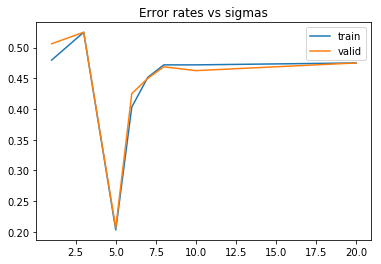

In [14]:
# Plot the sigmas vs errors
plt.plot(sigmas, Err_sig_train, label = 'train')
plt.plot(sigmas, Err_sig_valid, label = 'valid')
plt.title("Error rates vs sigmas")
plt.legend() # And hence we choose C = 100
plt.savefig("hw2_kernel_svm_sigmas")

In [15]:
# For efficiency, use 10% of the training set to get a c.
np.random.seed(1)
df_train_half = df_train.sample(frac=1/5)

k = 5 # Do a 5-fold CV
df_splitted = np.split(df_train_half,k,axis = 0)


C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]  

sig=5 # From the smallest test error above

Err_c_train = []
Err_c_valid = []
for c in C:
    err_c_train = []
    err_c_valid = []
    for i in range(k):
        X_valid, y_valid, X_train, y_train = get_train_valid(df_splitted, i, k)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_valid = np.array(X_valid)
        y_valid = np.array(y_valid)
        # Getting Gram matrix K
        K = get_Gram(X=X_train,sigma=sig)
        
        # Fitting model
        a,sv,svy,b0 = rbf_svm_train(X_train,y_train,C=c)
        
        # Predicting and calculating errors
        y_predict_train = rbf_svm_predict(X=X_train,true_a=a,true_svy=svy,true_sv=sv,b0=b0)
        y_predict_valid = rbf_svm_predict(X=X_valid,true_a=a,true_svy=svy,true_sv=sv,b0=b0)
        
        err_train = np.sum((y_predict_train!=y_train)*1)/len(y_train)
        err_valid = np.sum((y_predict_valid!=y_valid)*1)/len(y_valid)
        err_c_train.append(err_train)
        err_c_valid.append(err_valid)
        
    Err_c_train.append(np.average(err_c_train))
    Err_c_valid.append(np.average(err_c_valid))

     pcost       dcost       gap    pres   dres
 0: -1.1569e+02 -3.5778e+00  1e+03  3e+01  2e-15
 1: -4.5230e+00 -8.3007e-02  4e+01  1e+00  2e-15
 2: -7.2105e-02 -5.2646e-02  5e-01  1e-02  1e-15
 3: -2.0719e-02 -4.7884e-02  3e-02  2e-18  1e-15
 4: -2.3982e-02 -2.6678e-02  3e-03  4e-19  9e-16
 5: -2.4987e-02 -2.5374e-02  4e-04  3e-19  7e-16
 6: -2.4999e-02 -2.5005e-02  6e-06  3e-19  8e-16
 7: -2.5000e-02 -2.5000e-02  5e-07  3e-19  6e-16
 8: -2.5000e-02 -2.5000e-02  3e-07  3e-19  4e-16
 9: -2.5000e-02 -2.5000e-02  2e-07  3e-19  5e-16
10: -2.5000e-02 -2.5000e-02  1e-07  3e-19  5e-16
11: -2.5000e-02 -2.5000e-02  3e-08  5e-19  7e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1655e+02 -3.3337e+00  1e+03  3e+01  2e-15
 1: -4.2294e+00 -6.2969e-02  3e+01  1e+00  2e-15
 2: -6.3827e-02 -5.2231e-02  4e-01  1e-02  1e-15
 3: -2.0779e-02 -4.6711e-02  3e-02  1e-18  9e-16
 4: -2.3856e-02 -2.5616e-02  2e-03  3e-19  9e-16
 5: -2.4167e-02 -2.4241e-02  7e-05  7e-19  5e-1

     pcost       dcost       gap    pres   dres
 0: -1.1794e+02 -8.4494e+00  1e+03  3e+01  2e-15
 1: -5.6558e+00 -5.1795e+00  3e+01  9e-01  2e-15
 2: -2.1056e+00 -4.5313e+00  2e+00  1e-16  9e-16
 3: -2.4405e+00 -2.5967e+00  2e-01  5e-17  1e-15
 4: -2.5370e+00 -2.5561e+00  2e-02  6e-17  6e-16
 5: -2.5376e+00 -2.5391e+00  2e-03  6e-17  5e-16
 6: -2.5378e+00 -2.5388e+00  1e-03  7e-17  5e-16
 7: -2.5378e+00 -2.5389e+00  1e-03  4e-17  5e-16
 8: -2.5380e+00 -2.5387e+00  7e-04  4e-17  5e-16
 9: -2.5380e+00 -2.5387e+00  7e-04  4e-17  4e-16
10: -2.5380e+00 -2.5387e+00  7e-04  5e-17  5e-16
11: -2.5383e+00 -2.5384e+00  7e-05  4e-17  7e-16
12: -2.5383e+00 -2.5383e+00  2e-06  3e-17  7e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1745e+02 -8.6150e+00  1e+03  3e+01  2e-15
 1: -4.9774e+00 -5.2351e+00  3e+01  7e-01  2e-15
 2: -2.1147e+00 -4.4408e+00  2e+00  1e-16  9e-16
 3: -2.4328e+00 -2.5832e+00  2e-01  4e-17  8e-16
 4: -2.4775e+00 -2.4824e+00  5e-03  3e-17  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.2941e+02 -5.3732e+02  1e+03  2e+00  4e-15
 1: -1.9050e+02 -3.5645e+02  2e+02  1e-15  3e-15
 2: -2.2327e+02 -2.3976e+02  2e+01  5e-15  4e-15
 3: -2.2456e+02 -2.3396e+02  9e+00  6e-15  4e-15
 4: -2.2537e+02 -2.3170e+02  6e+00  5e-15  4e-15
 5: -2.2642e+02 -2.2951e+02  3e+00  5e-15  4e-15
 6: -2.2687e+02 -2.2875e+02  2e+00  3e-15  3e-15
 7: -2.2730e+02 -2.2810e+02  8e-01  1e-15  3e-15
 8: -2.2748e+02 -2.2785e+02  4e-01  2e-16  3e-15
 9: -2.2755e+02 -2.2776e+02  2e-01  1e-15  4e-15
10: -2.2759e+02 -2.2769e+02  1e-01  7e-16  3e-15
11: -2.2763e+02 -2.2765e+02  2e-02  7e-16  4e-15
12: -2.2764e+02 -2.2764e+02  2e-03  1e-15  4e-15
13: -2.2764e+02 -2.2764e+02  5e-05  9e-16  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.8466e+02 -1.0440e+04  1e+04  3e-14  2e-14
 1: -1.0625e+03 -2.2898e+03  1e+03  2e-14  2e-14
 2: -1.5772e+03 -1.7676e+03  2e+02  2e-16  3e-14
 3: -1.6607e+03 -1.6952e+03  3e+01  3e-14  4e-1

     pcost       dcost       gap    pres   dres
 0:  3.3151e+06 -4.6509e+07  5e+07  9e-13  2e-12
 1:  1.3154e+06 -4.8413e+06  6e+06  2e-12  2e-12
 2:  2.7013e+05 -6.1669e+05  9e+05  2e-12  2e-12
 3:  3.2764e+04 -1.5162e+05  2e+05  5e-13  1e-12
 4: -1.5585e+04 -9.7785e+04  8e+04  2e-12  1e-12
 5: -3.3542e+04 -7.6944e+04  4e+04  4e-12  2e-12
 6: -4.3935e+04 -6.6643e+04  2e+04  5e-12  2e-12
 7: -4.8080e+04 -6.2458e+04  1e+04  3e-12  2e-12
 8: -5.1292e+04 -5.9097e+04  8e+03  5e-12  2e-12
 9: -5.3782e+04 -5.6515e+04  3e+03  5e-12  2e-12
10: -5.4962e+04 -5.5287e+04  3e+02  2e-12  2e-12
11: -5.5093e+04 -5.5142e+04  5e+01  9e-13  2e-12
12: -5.5114e+04 -5.5118e+04  4e+00  9e-13  2e-12
13: -5.5116e+04 -5.5116e+04  7e-02  5e-12  2e-12
14: -5.5116e+04 -5.5116e+04  8e-04  9e-13  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.8248e+06 -4.1335e+07  4e+07  6e-13  2e-12
 1:  1.1564e+06 -4.8488e+06  6e+06  3e-13  2e-12
 2:  2.4654e+05 -6.4334e+05  9e+05  1e-13  2e-1

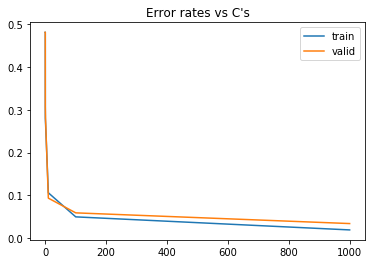

In [16]:
# Plot the sigmas vs errors
plt.plot(C, Err_c_train, label = 'train')
plt.plot(C, Err_c_valid, label = 'valid')
plt.title("Error rates vs C's")
plt.legend() # And hence we choose C = 100
plt.savefig("hw2_kernel_svm_C")

In [18]:
# For efficiency, use 10% of the training set to get a c.
np.random.seed(1)
df_train_shuffled = df_train.sample(frac=1)
X_test, y_test = np.array(df_test.iloc[:,0:2]), np.array(df_test.iloc[:,2])
k = 10 # Do a 10-fold CV
df_splitted = np.split(df_train_shuffled,k,axis = 0)


C = 100 # From the smallest test error above

sig=5 # From the smallest test error above

Err_cv_train = []
Err_cv_valid = []
Err_cv_test = []
for i in range(k):
    X_valid, y_valid, X_train, y_train = get_train_valid(df_splitted, i, k)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_valid = np.array(X_valid)
    y_valid = np.array(y_valid)
    # Getting Gram matrix K
    K = get_Gram(X=X_train,sigma=sig)

    # Fitting model
    a,sv,svy,b0 = rbf_svm_train(X_train,y_train,C=c)

    # Predicting and calculating errors
    y_predict_train = rbf_svm_predict(X=X_train,true_a=a,true_svy=svy,true_sv=sv,b0=b0)
    y_predict_valid = rbf_svm_predict(X=X_valid,true_a=a,true_svy=svy,true_sv=sv,b0=b0)
    y_predict_test = rbf_svm_predict(X=X_test,true_a=a,true_svy=svy,true_sv=sv,b0=b0)

    err_train = np.sum((y_predict_train!=y_train)*1)/len(y_train)
    err_valid = np.sum((y_predict_valid!=y_valid)*1)/len(y_valid)
    err_test = np.sum((y_predict_test!=y_test)*1)/len(y_test)

    Err_cv_train.append(err_train)
    Err_cv_valid.append(err_valid)
    Err_cv_test.append(err_test)

     pcost       dcost       gap    pres   dres
 0:  3.8597e+07 -1.1576e+09  2e+09  5e-01  9e-12
 1:  3.3823e+07 -2.0792e+08  2e+08  2e-11  2e-11
 2:  1.0007e+07 -2.6264e+07  4e+07  2e-11  7e-12
 3:  1.9345e+06 -4.1976e+06  6e+06  1e-11  6e-12
 4:  3.2328e+05 -8.6408e+05  1e+06  4e-12  5e-12
 5:  2.5155e+04 -4.8345e+05  5e+05  3e-12  5e-12
 6: -4.3849e+04 -4.0146e+05  4e+05  7e-12  5e-12
 7: -1.0807e+05 -3.1679e+05  2e+05  7e-12  6e-12
 8: -1.3942e+05 -2.8054e+05  1e+05  2e-12  6e-12
 9: -1.5906e+05 -2.5804e+05  1e+05  3e-12  6e-12
10: -1.7504e+05 -2.3987e+05  6e+04  1e-11  6e-12
11: -1.8511e+05 -2.2856e+05  4e+04  1e-11  6e-12
12: -1.9100e+05 -2.2193e+05  3e+04  5e-12  6e-12
13: -1.9613e+05 -2.1593e+05  2e+04  5e-13  7e-12
14: -2.0092e+05 -2.1030e+05  9e+03  1e-12  7e-12
15: -2.0328e+05 -2.0746e+05  4e+03  1e-11  7e-12
16: -2.0457e+05 -2.0598e+05  1e+03  2e-11  8e-12
17: -2.0514e+05 -2.0539e+05  2e+02  2e-11  7e-12
18: -2.0526e+05 -2.0527e+05  1e+01  3e-11  8e-12
19: -2.0526e+05 -2.05

10: -1.7575e+05 -2.5135e+05  8e+04  2e-11  5e-12
11: -1.8646e+05 -2.4029e+05  5e+04  2e-11  5e-12
12: -1.9416e+05 -2.3194e+05  4e+04  2e-16  5e-12
13: -2.0138e+05 -2.2398e+05  2e+04  3e-12  5e-12
14: -2.0541e+05 -2.1961e+05  1e+04  1e-11  5e-12
15: -2.0914e+05 -2.1540e+05  6e+03  9e-13  5e-12
16: -2.1080e+05 -2.1348e+05  3e+03  5e-12  6e-12
17: -2.1158e+05 -2.1264e+05  1e+03  2e-16  5e-12
18: -2.1201e+05 -2.1218e+05  2e+02  6e-12  6e-12
19: -2.1209e+05 -2.1209e+05  3e+00  9e-13  6e-12
20: -2.1209e+05 -2.1209e+05  3e-02  1e-11  6e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.8920e+07 -1.2626e+09  3e+09  6e-01  8e-12
 1:  3.7051e+07 -2.8126e+08  3e+08  3e-11  2e-11
 2:  1.1312e+07 -2.6560e+07  4e+07  2e-11  7e-12
 3:  2.0718e+06 -3.5969e+06  6e+06  9e-13  6e-12
 4:  3.3205e+05 -7.9637e+05  1e+06  3e-12  5e-12
 5:  9.3067e+04 -5.5162e+05  6e+05  5e-12  4e-12
 6: -3.9599e+04 -3.8746e+05  3e+05  9e-13  5e-12
 7: -9.8492e+04 -3.2243e+05  2e+05  8e-12  5e-

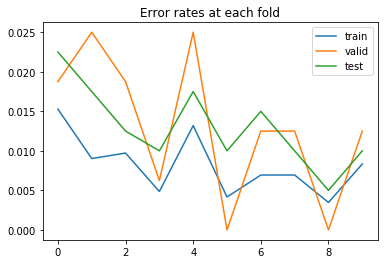

In [20]:
# Plot the sigmas vs errors
plt.plot(list(range(k)), Err_cv_train, label = 'train')
plt.plot(list(range(k)), Err_cv_valid, label = 'valid')
plt.plot(list(range(k)), Err_cv_test, label = 'test')
plt.title("Error rates at each fold")
plt.legend() # And hence we choose C = 100
plt.savefig("hw2_kernel_svm_cv.png")

In [22]:
!jupyter nbconvert --to script hw2_kernel_svm.ipynb

[NbConvertApp] Converting notebook hw2_kernel_svm.ipynb to script
[NbConvertApp] Writing 7291 bytes to hw2_kernel_svm.py
